In [1]:
import os
import numpy as np
import pandas as pd
import torch
import math
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score

Import transformer and initialize parameters for GPT-2 model. Set parameter presets.

In [2]:
import tokenizers
print(tokenizers.__version__)

0.12.1


In [3]:

import transformers
print(transformers.__version__)


4.18.0


In [4]:
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

e:\Program Files\miniconda3\envs\project\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [5]:
# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 8

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 200

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

Prepare dataset for GPT-2. Would like to use GPT-3, but it can only be accessed by openai API and there are charges for large amount of tokens requested.

In [6]:
INPUT_DIR = 'book-covers-details'
OUTPUT_DIR = 'book-covers-detials-sorted'

DATA_DIR = "book-covers"

CATEGORIES = next(os.walk(DATA_DIR), (None, None, []))[1]
# print(CATEGORIES)

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {CATEGORIES[i]:i for i in range(len(CATEGORIES))}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)
print(labels_ids)
print(n_labels)

{'Art-Photography': 0, 'Biography': 1, 'Business-Finance-Law': 2, 'Childrens-Books': 3, 'Computing': 4, 'Crafts-Hobbies': 5, 'Crime-Thriller': 6, 'Dictionaries-Languages': 7, 'Entertainment': 8, 'Food-Drink': 9, 'Graphic-Novels-Anime-Manga': 10, 'Health': 11, 'History-Archaeology': 12, 'Home-Garden': 13, 'Humour': 14, 'Medical': 15, 'Mind-Body-Spirit': 16, 'Natural-History': 17, 'Personal-Development': 18, 'Poetry-Drama': 19, 'Reference': 20, 'Religion': 21, 'Romance': 22, 'Science-Fiction-Fantasy-Horror': 23, 'Science-Geography': 24, 'Society-Social-Sciences': 25, 'Sport': 26, 'Stationery': 27, 'Teaching-Resources-Education': 28, 'Technology-Engineering': 29, 'Teen-Young-Adult': 30, 'Transport': 31, 'Travel-Holiday-Guides': 32}
33


In [14]:
def sort_book_description(OUTPUT_DIR, CATEGORIES):
    book_info_train = pd.DataFrame(columns=['text', 'label'])
    book_info_val = pd.DataFrame(columns=['text', 'label'])
        
    for category in CATEGORIES:
        book_detail_path = os.path.join(OUTPUT_DIR, category+".csv")
        print("Now running on:", category)       
        book_info = pd.read_csv(book_detail_path)
        # book_info.description = book_info.description.fillna("")
        # book_info['info'] = book_info.name + book_info.description
        # book_info = book_info[['info', 'category']]
        # book_info = book_info.rename(columns={'info':'text', 'category':'label'})
        # temp_train, temp_val = np.split(book_info, [int(.85 * len(book_info)), int(.15 * len(book_info))])
        # n_val = math.floor(len(book_info*0.15))
        # n_train = len(book_info) - n_val
        temp_train = book_info[['text', 'label']].sample(frac=0.85)
        book_info_train = book_info_train.append(temp_train)
        book_info_val = book_info_val.append(book_info.drop(temp_train.index))
        book_info_val = book_info_val[['text', 'label']]
        print(len(book_info_train), len(book_info_val))
        # break # for testing purpose
    book_info_train.to_csv(os.path.join(OUTPUT_DIR, "book_info_train.csv"))
    book_info_val.to_csv(os.path.join(OUTPUT_DIR, "book_info_val.csv"))
        

The sorting method only need run once.

In [15]:
sort_book_description(OUTPUT_DIR, CATEGORIES)

Now running on: Art-Photography
835 147
Now running on: Biography
1675 295
Now running on: Business-Finance-Law
2516 443
Now running on: Childrens-Books
3354 591
Now running on: Computing
4193 739
Now running on: Crafts-Hobbies
5035 887
Now running on: Crime-Thriller
5875 1035
Now running on: Dictionaries-Languages
6715 1183
Now running on: Entertainment
7544 1329
Now running on: Food-Drink
8385 1477
Now running on: Graphic-Novels-Anime-Manga
9225 1625
Now running on: Health
10066 1773
Now running on: History-Archaeology
10907 1921
Now running on: Home-Garden
11748 2069
Now running on: Humour
12589 2217
Now running on: Medical
13430 2365
Now running on: Mind-Body-Spirit
14271 2513
Now running on: Natural-History
15112 2661
Now running on: Personal-Development
15951 2809
Now running on: Poetry-Drama
16793 2957
Now running on: Reference
17633 3105
Now running on: Religion
18473 3253
Now running on: Romance
19304 3400
Now running on: Science-Fiction-Fantasy-Horror
20145 3548
Now running o

In [7]:
class BookDescriptionDataset(Dataset):
    def __init__(self, path, use_tokenizer):
        if not os.path.exists(path):
            raise ValueError('Invalid path variable.')
        
        book_info = pd.read_csv(path)
        self.texts = book_info['text'].values
        self.labels = book_info['label'].values
        self.n_examples = len(self.labels)
    
    def __len__(self):
        return self.n_examples

    def __getitem__(self, item):
        return {'text': self.texts[item],
                'label': self.labels[item]}
        

In [8]:
class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

In [9]:
def train(dataloader, optimizer_, scheduler_, device_):

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer_.step()

    # Update the learning rate.
    scheduler_.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    torch.cuda.empty_cache()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

In [10]:
def validation(dataloader, device_):
  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

In [11]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [12]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = BookDescriptionDataset(path=os.path.join(OUTPUT_DIR, 'book_info_train.csv'), 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  BookDescriptionDataset(path=os.path.join(OUTPUT_DIR,'book_info_val.csv'), 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 27702 examples!
Created `train_dataloader` with 3463 batches!

Dealing with Validation...
Created `valid_dataset` with 4879 examples!
Created `eval_dataloader` with 610 batches!


Epoch


e:\Program Files\miniconda3\envs\project\lib\site-packages\transformers\optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/3463 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/610 [00:00<?, ?it/s]

  train_loss: 2.68866 - val_loss: 2.29366 - train_acc: 0.27280 - valid_acc: 0.36585


Training on batches...


  0%|          | 0/3463 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/610 [00:00<?, ?it/s]

  train_loss: 2.18323 - val_loss: 2.20276 - train_acc: 0.38781 - valid_acc: 0.37508


Training on batches...


  0%|          | 0/3463 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/610 [00:00<?, ?it/s]

  train_loss: 1.99930 - val_loss: 2.17351 - train_acc: 0.42398 - valid_acc: 0.38123


Training on batches...


  0%|          | 0/3463 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/610 [00:00<?, ?it/s]

  train_loss: 1.87236 - val_loss: 2.17643 - train_acc: 0.45419 - valid_acc: 0.38082



e:\Program Files\miniconda3\envs\project\lib\site-packages\ml_things\plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


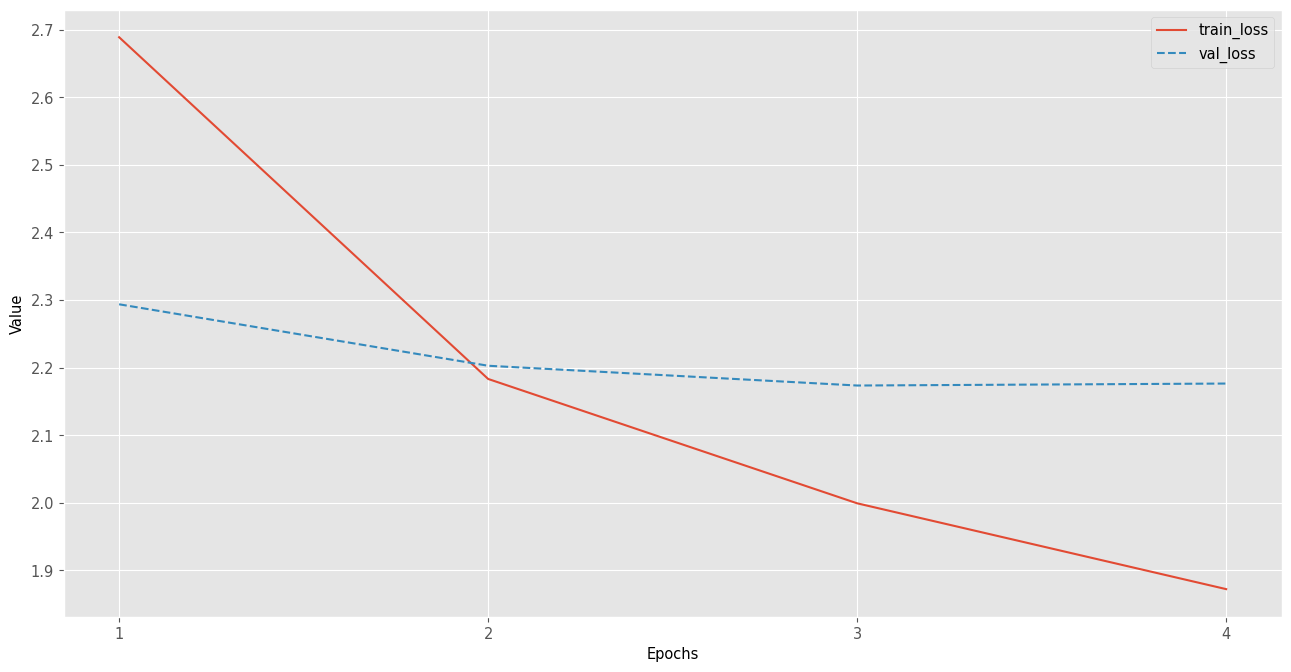

e:\Program Files\miniconda3\envs\project\lib\site-packages\ml_things\plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


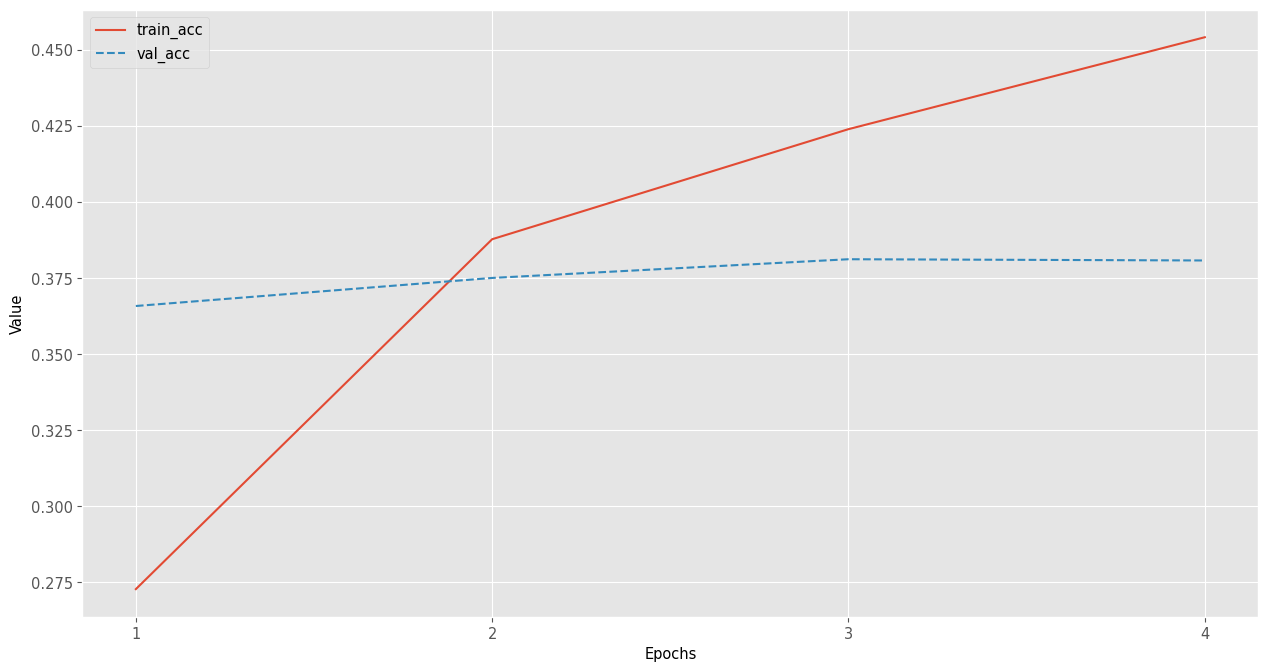

In [13]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    # Get prediction form model on validation data. 
    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves.
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    # Store the loss value for plotting the learning curve.
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [14]:
MODEL_PATH = "fine_tuned_models_gpt2_2\\model"
TOKENIZER_PATH = "fine_tuned_models_gpt2_2\\tokenizer"

In [15]:
model.save_pretrained(MODEL_PATH)
tokenizer.save_pretrained(TOKENIZER_PATH)

('fine_tuned_models_gpt2_2\\tokenizer\\tokenizer_config.json',
 'fine_tuned_models_gpt2_2\\tokenizer\\special_tokens_map.json',
 'fine_tuned_models_gpt2_2\\tokenizer\\vocab.json',
 'fine_tuned_models_gpt2_2\\tokenizer\\merges.txt',
 'fine_tuned_models_gpt2_2\\tokenizer\\added_tokens.json')

  0%|          | 0/610 [00:00<?, ?it/s]

                                precision    recall  f1-score   support

               Art-Photography       0.16      0.08      0.11       147
                     Biography       0.15      0.14      0.15       148
          Business-Finance-Law       0.35      0.45      0.39       148
               Childrens-Books       0.35      0.39      0.36       148
                     Computing       0.51      0.62      0.56       148
                Crafts-Hobbies       0.50      0.49      0.50       148
                Crime-Thriller       0.39      0.43      0.41       148
        Dictionaries-Languages       0.48      0.47      0.48       148
                 Entertainment       0.42      0.58      0.49       146
                    Food-Drink       0.58      0.63      0.61       148
    Graphic-Novels-Anime-Manga       0.65      0.61      0.63       148
                        Health       0.24      0.22      0.23       148
           History-Archaeology       0.32      0.43      0.36  

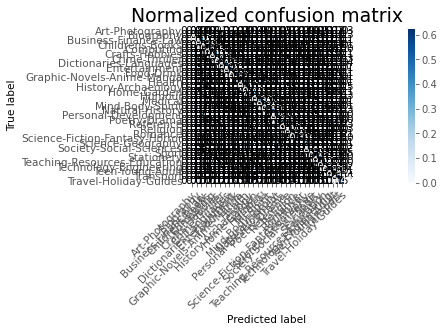

In [32]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );